# DOPP 2021W Exercise 3
## Group 33 - Topic 8 (Endangered Animals)
* 01526884 - Sebastian Scholz
* 01634043 - Dominik Mailer
* xy - AB
* xy - AB

## General Comments
The package for plotting interactive diagrams `plotly.express` may need to be installed before the notebook can be run. The library `geopandas` is necessary in order to plot maps.

### Work Distribution

In [2]:
# all required imports

import iucn_data
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as pgd 
import pandas as pd 
import numpy as np
import math
from shapely import wkt
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression 
from matplotlib.pyplot import figure
from prophet import Prophet
from prophet.plot import plot_forecast_component, plot_yearly, add_changepoints_to_plot

ModuleNotFoundError: No module named 'iucn_data'

In [ ]:
# Which dataset(s) did you choose? Why?
# How did you clean/transform the data? Why?
# How did you solve the problem of missing values? Why?
# What questions did you ask of the data?
# Why were these good questions?
# What were the answers to these questions?
# How did you obtain them?
# Do the answers make sense?
# Were there any difficulties in analysing the data?
# What were the key insights obtained?
# What are potential biases in the data and analysis?
# Which Data Science tools and techniques were learned during this exercise?
# How was the work divided up between the members of the group?

## Introduction
To answer the questions we relied primarily on the International Union for Conservation of Nature's _IUCN Red List of Threatened Species_ [1]. The Red List, founded in 1964, is regarded as the most authoritative and complete list to the conservatory status of species. Using a set of precise criteria it assesses the extinction risk of most species and even subspecies. For each species (or subspecies) a threat level is defined, possible threat levels are:
- Least Concern (LC)
- Near Threatened (NT)
- Vulnerable (VU)
- Endangered (EN)
- Critically Endangered (CR)
- Extinct in the Wild (EW)
- Extinct (EX)
- additionally: Data Deficient (DD)/Not Evaluated (NE)

The IUCN aims to reassess each species at least every 5-10 years. Additionally, to these thread levels information like habitat or threats are published. The data is provided in two ways, either as direct download [2] or as API [3]. Due to the sheer size of the directly downloadable data (multiple Gigabytes due to specific habitat polygons and multiple other, for us, irrelevant fields), and the fact that some species would not be included in this download (e.g. all Birds), we opted to directly use the API. Utilizing the provided API we were able to download only information which we need and thus greatly reduced the size of our raw data. Since the questions are concerned with threatened species, we opted to only include species currently in the categories _CR_ and _EN_.

### API description
The first step was to query the species of interest (category CR and EN), from the endpoint `/api/v3/species/category/:category`, using this list, and resulting taxon ids the remaining information was taken from the following endpoints: `/api/v3/species/id/:id`, `/api/v3/species/countries/id/:id`, `/api/v3/species/history/id/:id`, `/api/v3/threats/species/id/:id`, `/api/v3/habitats/species`.

Aside of the category end-point each of these, required us to traverse our species list and create a single new API-call for each. This constraint resulted in long loading times since a new connection needed to be established for each single call. Our solution was to split the work into multiple batches, so that querying could be stopped and resumed after some time instead of having to wait multiple hours per endpoint. These batches were written into separate csv-files.

## Description of *iucn_data*
The file `iucn_data.py` contains the logic to read csv-files which were generated using the aforementioned API. Due to size and high response times each query process was done in batches so that work could be paused and resumed, after certain intervals, `icun_data.py` merges these batches (in one instance also two datasets) and ensures that everyone works with the same data-structure. Specifically the following methods are provides: `get_merged_country_info()` for data regarding the distribution area of species, `get_merged_historical_info()` for historical assessments of species, `get_merged_habitat_info()` provides information about the habitat species live in (e.g. Forest or Desert), `get_merged_threats_info()` returns information regaring the current threats, and finally `get_animalia_df()` provides the list of species we consider for this exercise (a more accurat description of each returned dataframe can be found below). For each of these dataframes two fields can be used as keys for operations such as joins or merges, firstly `taxonid_iucn` is an interal, unique ID assigned by the IUCN, secondly the `scientific name` of each species is unique and can also be considered an ID.

## Sources
[1] <https://www.iucnredlist.org/>
[2] <https://www.iucnredlist.org/resources/grid>
[3] <http://apiv3.iucnredlist.org/api/v3/docs>

## DataFrame Description and Data Preparation
After the data gathering and column selection we ended up with five dataframes:

* *animalia_df*
* *historical_df*
* *threats_df*
* *habitat_df*
* *countries_df*

*animalia_df* is the main dataframe and the other four have additional information that can be easily combined based on the *taxonid_iucn*.

### *animalia_df*
Contains all information about the species such as the unique identifier *taxonid_iucn*, but also the scientific name and taxonomic information (e.g. kingdom, phylum, class, etc.).
In addition, the threat category (e.g., CR or EN) is also included in this data frame.
All other information is not of great interest for answering these questions.
All available columns are listed afterwards in the dataframe analysis.

### *historical_df*
Contains information about the historical assessment of all species from the *animalia_df*.
Therefore, in addition to the *taxonid_iucn*, this data frame also contains the year in which a particular assessment was made and the category with the unique category code (e.g. CR or EN).
All available columns are listed afterwards in the dataframe analysis.

### *threats_df*
Contains, for the species (identified by *taxonid_iucn*), all threats that contribute to its vulnerability, e.g. logging and timber harvest, fire, roads and railroads, droughts, etc.
Each species can have from 0 to n threats associated with it.
All available columns are listed afterwards in the dataframe analysis.

### *habitat_df*
Contains for the species (identified by *taxonid_iucn*) all habitats where it can possibly occur.
Habitat information includes, for example, forests with more specific information such as subtropical or tropical forests, but also wetlands, deserts, coastal areas, etc.
Suitability and season information is also provided.
Between 0 and n habitats can be assigned to each species.
All available columns are listed afterwards in the dataframe analysis.

### *countries_df*
Primarily contains the information in which countries an animal can occur or was observed in the past.
Again, the species can be linked to the country information via the *taxonid_iucn*.
For the countries, there is a two-digit and a three-digit code (ISO alpha-2 and ISO alpha-3 codes), the continent, the subregion, and also the occurrence of the animal in that country (e.g., extant or possibly extinct).
The original country information we received from IUCN did not include so much country information. Therefore, we enriched it with an additional country-continent file to obtain the ISO alpha-3 country code in addition to the continent and subregion information.
Between 0 and n countries can be assigned to each species.
All available columns are then listed in the data frame analysis.

## Data Quality Checks
In the following, some basic data quality checks are performed to determine if data is missing and, if so, what we can do about it.
For this purpose, a method plots all columns where values are missing and how many values are missing there.
These numbers are visually supported with bar charts to depict the findings.
This method is applied to each of the data frames.

Additionally, the column data types and some basic data frame information are printed as well for each data frame.


In [ ]:
# check for missing values, data types and so on
animalia_df = iucn_data.get_animalia_df()
historical_df = iucn_data.get_merged_historical_info()
threats_df = iucn_data.get_merged_threats_info()
habitat_df = iucn_data.get_merged_habitat_info()
countries_df = iucn_data.get_merged_country_info()


def print_missing_values_summary(df, title, textual_output=False):
    nr_missing_values = df.isna().sum()

    if textual_output:
        print(f"\n\nEvaluation of missing values for {title}:")
        # number of missing values in total
        print(nr_missing_values[nr_missing_values > 0])

    if nr_missing_values[nr_missing_values > 0].size != 0:
        nr_missing_values[nr_missing_values > 0].plot.bar()
        plt.xlabel("Column")
        plt.ylabel("Number of Missing Values")
        plt.title(f"Missing values (only columns with missing values are given) - {title}")
        plt.gcf().subplots_adjust(bottom=0.4)
        plt.show()
    else:
        print(f'No missing values for {title}')


print("\nAnimal Data - Datatypes/Dataframe-Information:")
print(animalia_df.info())

print("\nHistorical Assessment Data - Datatypes/Dataframe-Information:")
print(historical_df.info())

print("\nThreats Data - Datatypes/Dataframe-Information:")
print(threats_df.info())

print("\nHabitat Data - Datatypes/Dataframe-Information:")
print(habitat_df.info())

print("\nCountry Occurrence Data - Datatypes/Dataframe-Information:")
print(countries_df.info())

print_missing_values_summary(animalia_df, "Animal Data")
print_missing_values_summary(historical_df, "Historical Assessment Data")
print_missing_values_summary(threats_df, "Threats Data")
print_missing_values_summary(habitat_df, "Habitat Data")
print_missing_values_summary(countries_df, "Country Occurrence Data")

species_df = animalia_df.reset_index()
country_occurrences_merged = countries_df.reset_index()
historical_info_merged = historical_df.reset_index()
habitat_info_merged = habitat_df.reset_index()
threats_info_merged = threats_df.reset_index()

print('\nChecks what additional information is missing (when merged) for species:')
species_without_countries = list(set(species_df['taxonid_iucn'].unique()) - set(country_occurrences_merged['taxonid_iucn'].unique()))
print(f'Species without country occurrence: {len(species_without_countries)}')

species_without_hist_info = list(set(species_df['taxonid_iucn'].unique()) - set(historical_info_merged['taxonid_iucn'].unique()))
print(f'Species without hist info: {len(species_without_hist_info)}')

species_without_habitat_info = list(set(species_df['taxonid_iucn'].unique()) - set(habitat_info_merged['taxonid_iucn'].unique()))
print(f'Species without habitat info: {len(species_without_habitat_info)}')

species_without_threats_info = list(set(species_df['taxonid_iucn'].unique()) - set(threats_info_merged['taxonid_iucn'].unique()))
print(f'Species without threats info: {len(species_without_threats_info)}')

print('\nEvaluation on missing codes for Historical Assessment Data:')
print(historical_df[historical_df.isnull().any(axis=1)])

# Calculating statistical information (mean, std, etc.) is not feasible for these data because they are almost exclusively categorical.
# No real outlier handling possible (almost only categorical data).
# Missing values could only be corrected manually (not feasible), as we are unable to add habitat or threat information to animals where this information is missing.

## Comments on Data Quality

At first glance, it looks as if many values are already missing in the main dataframe and also in the other dataframes it looks as if many values are missing.
However, the missing values only occur in columns that we would not use to answer our questions anyway. Accordingly, these missing values are not a problem.

For example, in the *animals_df* we do not use the field *subspecies* or *rank* and also all the other fields are not used by us, because they are partly based on such a deep granularity, which we do not use anyway.

Also in the threats dataframe the columns that contain missing values are not needed any further. The same is true for the Habitat information.

Only for Historical Assessment Data we are missing 70 codes and this column is also used.
However, since the caption is available for these 70 lines and also the year of the assessment, we can see that these values are all from 1965 and also do not directly describe the status "Endangered" or "Critically Endangered", on which we have put the actual attention.
Therefore, these missing values are also negligible.

**Lesson Learned**
An important lesson learned when checking for missing values and assessing data quality was that, by default, when importing csv files, several strings (with a certain format) are considered as missing values - *nan*.
For example, the string "NA" (the ISO alpha-2 country code of Namibia) was always displayed as *nan* in the data frame, even though it was present in the file.
The solution to this problem was that with the `keep_default_na=False` option and without specifying *na_values*, no strings are parsed as *nan*.

### Handling Missing Values and Outliers
From the listed data types and by inspecting the files and column names, you can see very quickly that the data we are using here are exclusively categorical values.
Therefore, a calculation and description based on descriptive statistics (mean, std, etc.) is not possible and also a meaningful outlier detection is not feasible.
There was also no need to clean and transform the data, again largely due to the categorical data.

As mentioned earlier, we were able to address the lack of additional country information by integrating an additional file so that we have all the information we need to answer the questions.

Missing values for species without country occurrence, habitat information or threat information could only be corrected manually.
However, this is not feasible as we are not able to add habitat or threat information to animals where this information is missing because we do not have the necessary expertise (no biologists).

### Conclusions on Data Quality
In summary, the quality of the data we got through IUCN API calls is really very good and is in fact complete (at least the fields and information we need) and also the codes and other information, for example for countries or endangerment status are consistent and plausible throughout.
Also, the *taxonid_iucn* in combination with the scientific name is unique for all entries.

## Question 1 - General Insights on Endangered Species
* How many species are currently listed as endangered?
    * How many animals are endangered in certain continents/areas/countries?
    * How many animals are endangered for a certain class (taxonomic rank; e.g., Mammalia)?
    * What are the main threats for certain classes?
* How has this changed over time?
    * How has the number of endangered and critical endangered animals changed over time?

In the following, these questions are answered using the data prepared and analyzed above.

**Note:** The Pie Charts and some of the Bar Charts are interactive.
This means that by clicking on the legend, categories (pie slices or bars) can be hidden and then displayed again.

In [ ]:
# constants
common_phyla_names = {
    'CHORDATA': 'Chordates',
    'ARTHROPODA': 'Arthropods',
    'MOLLUSCA': 'Mollusks',
    'CNIDARIA': 'Cnidarians',
    'ANNELIDA': 'Segmented worms',
    'ECHINODERMATA': 'Echinoderms',
    'ONYCHOPHORA': 'Velvet worms',
    'NEMERTINA': 'Ribbon worms'
}

animalia_df = iucn_data.get_animalia_df()
threats_df = iucn_data.get_merged_threats_info()

# columns
# ['scientific_name', 'subspecies', 'rank', 'subpopulation',
#        'threatCategory', 'kingdom', 'phylum', 'class', 'order', 'family',
#        'genus', 'main_common_name', 'authority', 'published_year',
#        'assessment_date', 'category', 'criteria', 'population_trend',
#        'marine_system', 'freshwater_system', 'terrestrial_system', 'assessor',
#        'reviewer', 'aoo_km2', 'eoo_km2', 'elevation_upper', 'elevation_lower',
#        'depth_upper', 'depth_lower', 'errata_flag', 'errata_reason',
#        'amended_flag', 'amended_reason']
# print(animalia_df.columns)
# print(animalia_df.head(20))

# How many species are endangered?
count_overall = animalia_df['scientific_name'].nunique()
print(f"There are {count_overall} endangered species in total.")

# critical endangered
count_cr = animalia_df[animalia_df['threatCategory'] == 'CR']['scientific_name'].nunique()
print(f"Thereof are {count_cr} critical endangered.")

# endangered
count_en = animalia_df[animalia_df['threatCategory'] == 'EN']['scientific_name'].nunique()
print(f"Thereof are {count_en} endangered.")

# PIE CHART
# define data
df = animalia_df.groupby('threatCategory').size().reset_index(name='counts')

labels = ['Critical Endangered', 'Endangered']

fig = px.pie(df, values='counts', names=labels,
             title='Breakdown of endangered and critical endangered species',
             color_discrete_sequence=["indianred", "darkred"])
fig.show()

# BAR CHART with phylum and class
df_bar_gen = animalia_df.groupby(['phylum', 'class'])['scientific_name'].count().to_frame()
df_bar_gen.sort_values(by=['phylum', 'scientific_name'], ascending=[True, False], inplace=True)
df_bar_gen.columns = ['counts']
df_bar_gen = df_bar_gen.reset_index()
fig = px.bar(df_bar_gen, x='counts', y='class', color='phylum', text_auto='s',
             title='Breakdown of endangered (CR and EN) species by Phylum and class',
             orientation='h')
fig.show()

# How many animals are endangered for a certain class (taxonomic rank; e.g., Mammalia)?
# by subphylum
df = animalia_df.groupby('phylum').size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
df['phylum'] = df['phylum'].map(common_phyla_names)
# print(df)

fig = px.pie(df, values='counts', names='phylum',
             title='Breakdown of endangered (EN and CR) species by Phylum')
fig.show()

# most interesting Phylum categories: Chordates, Arthropods, Mollusks
interesting_cat = ['CHORDATA', 'ARTHROPODA', 'MOLLUSCA']
df_red = animalia_df.query('phylum in @interesting_cat')
df_red = df_red.groupby(['phylum', 'class'])['scientific_name'].count().to_frame()
df_red.sort_values(by=['phylum', 'scientific_name'], ascending=[True, False], inplace=True)
df_red.columns = ['counts']
# print(df_red)

df_bar = df_red.reset_index()
fig = px.bar(df_bar, x='counts', y='class', color='phylum', orientation='h',
             title='Breakdown - CR and EN species by interesting Phylum and class',
             text_auto='s')
fig.show()

df_p = animalia_df.query('phylum in @interesting_cat').groupby(['phylum', 'class']) \
    .size().reset_index(name='counts') \
    .sort_values(by=['phylum', 'counts'], ascending=[True, False])

for cat in interesting_cat:
    fig = px.pie(df_p[df_p['phylum'] == cat], values='counts', names=df_p[df_p['phylum'] == cat]['class'].unique(),
                 title=f'Number of endangered animals in {cat}')
    fig.show()

# widely known animal classes are INSECTA, AMPHIBIA, REPTILIA, MAMMALIA, AVES (birds), ACTINOPTERYGII (ray-finned fish, which includes most familiar bony fish)
# how much of the total number of endangered animals are one of these classes
df_c = animalia_df.groupby(['class', 'threatCategory'])['scientific_name'].count().to_frame()
df_c.columns = ['counts']
#print(df_c)

df_cr_plt = df_c.reset_index()

f, ax = plt.subplots(figsize=(10, 15))
sns.barplot(x='counts', y='class', hue='threatCategory', data=df_cr_plt,
            palette=["darkred", "indianred"],
            capsize=0.05,
            saturation=8
            )
ax.legend(ncol=2, loc='lower right')
plt.title('Breakdown of endangered species by Class and Threat Category')
plt.gcf().subplots_adjust(left=0.25)
plt.show()

# focus on those with interesting class
interesting_classes = ['INSECTA', 'AMPHIBIA', 'REPTILIA', 'MAMMALIA', 'AVES', 'ACTINOPTERYGII']
df_c_red = df_c.reset_index().query('`class` in @interesting_classes')
df_c_red_ind = df_c_red.set_index(['class', 'threatCategory'])
#print(df_c_red_ind)

sns.barplot(x='counts', y='class', hue='threatCategory', data=df_c_red,
            palette=["darkred", "indianred"],
            capsize=0.05,
            saturation=8
            )
plt.title('BD of end. species by Class and Threat Category (interesting classes)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
      fancybox=True, shadow=True, ncol=5)
plt.gcf().subplots_adjust(left=0.25)
plt.show()


threats = animalia_df.join(threats_df)
threats = threats.query('`class` in @interesting_classes')
threats = threats[['class', 'title']]
threats = threats.groupby(['class', 'title']) \
    .size().reset_index(name='counts') \
    .sort_values(by=['class', 'counts'], ascending=[True, False])
print('\nTop 10 Threats per (interesting) class:')
for cls in interesting_classes:
    print(threats.query(f'`class` == "{cls}"').head(10))


## How did it change over time?
hist_df = iucn_data.get_merged_historical_info().reset_index()
cat = ["Endangered", "Critically Endangered", "Vulnerable"]
label_mapping = {"Critically Endangered":"CR", "Endangered":"EN", "Vulnerable":"VU"}
cat_cols = ["indianred", "lightblue", "darkred"]
df = hist_df.query(f'category in {cat}')

df['category'] = df['category'].map(label_mapping)

df = df.groupby(['taxonid_iucn', 'category'])['year'].min().reset_index()
df = df.groupby(['year', 'category']).count()
df.columns = ['counts']

df['no_csum'] = df.groupby(['category'])['counts'].cumsum()

sns.lineplot(x='year', y='no_csum', hue='category', palette=cat_cols, data=df)
plt.title('Historical development of sum of endangered species')
plt.show()

df_splt = df.reset_index()
sns.catplot(
    data=df_splt, kind="bar",
    x="year", y="no_csum", hue="category", palette=cat_cols, height=6
)
plt.xticks(rotation=90)
plt.title('Historical development of sum of endangered species')
plt.show()

cat_cols = {
    "Lower Risk/least concern": "green",
    "Vulnerable": "lightblue",
    "Endangered": "darkred",
    "Critically Endangered": "indianred"
}
cat = ["Lower Risk/least concern", "Vulnerable", "Endangered", "Critically Endangered"]
df = hist_df.query(f'category in {cat}')
df = df.groupby(['year', 'category'], as_index=False).size()
sns.catplot(data=df, kind="bar",
            x='year', y='size', hue='category',
            height=6, aspect=3, palette=cat_cols, legend=False,
            hue_order=["Lower Risk/least concern", 'Vulnerable', 'Endangered',  "Critically Endangered"])
plt.xticks(rotation=45)
plt.legend(loc='center left',)
plt.ylabel('Assessments')
plt.title('Categorical Assessments in Year')
plt.tight_layout()
plt.show()

## Comments on the Results of the First Set of Question
In hindsight, the initial questions were quite good, as the answers were quite informative and provided a rough overview of the topic, allowing us to check later findings to see if they were correct.
For example, whether the sum of the details matched the numbers we initially received without further differentiation on a more general level.

All our analyses and the prepared data focus on the kingdom of animals, according to the [taxonomic ranking](https://en.wikipedia.org/wiki/Taxonomic_rank).
Other kingdoms would be plants or fungi.
The further classification hierarchy is: Kingdom -> Phylum -> Class -> Order -> Family -> Genus -> Species

We started with the total number of endangered and critically endangered animals (kingdom level).
Building on this, we went one level down in the hierarchy and looked at the phylum level.
There, we looked at the distribution among the respective phylum categories and based on these findings, we selected three main categories: _CHORDATA_, _ARTHROPODA_, _MOLLUSCA_.

**CHORDATA**: "With a cord" - Hollow dorsal nerve cord, notochord, pharyngeal slits, endostyle, post-anal tail.
Pandas, crows, sharks, salamanders, alligators, sea squirts, and many others are examples of chordates
Thus, amphibians, reptiles, and mammals are classes that belong to this group.

**ARTHROPODA**: "Jointed foot" - Segmented bodies and jointed limbs, with Chitin exoskeleton.
Lobsters, crabs, spiders, mites, insects, centipedes, and millipedes, for instance, belong to this category.

**MOLLUSCA**: "Soft" - Muscular foot and mantle round shell.
Molluscs include mussels, scallops, oysters, periwinkles, whelks, squid, clams, snails, and octopus.

Sources:
* <https://en.wikipedia.org/wiki/Phylum>
* <https://www.biologyonline.com/dictionary/chordata>
* <https://www.britannica.com/animal/arthropod>
* <https://www.vedantu.com/biology/mollusca>

Based on these findings we again selected promising classes, both known classes and those with many endangered animals.
The selection includes *INSECTA* (insects), *AMPHIBIA* (amphibians), *REPTILIA* (reptiles), *MAMMALIA* (mammals), *AVES* (birds), *ACTINOPTERYGII* (ray-finned fish, which includes most familiar bony fish).

For all these analyses, both graphs and tabular outputs were produced.

In addition, the main threats were also listed for species classes of interest.
For each class, the top 10 threats were listed.
The number indicates how often this hazard was indicated as being endangering to this class.

Then we also looked at how the number of endangered animals has developed and changed (worsened) over the years.
For this purpose, we used the information from the historical assessments.
For each animal in combination with the threat status, we took the smallest year in which the status appeared for the first time and then calculated a cumulative sum per year.
Thus, one can see how the numbers have increased over time.
Downgrades in endangerment status almost did not take place.

In [ ]:
def fix_missing_codes(world):
    # just done because of an existing bug - https://github.com/geopandas/geopandas/issues/1041
    world2 = world.copy()
    world2.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
    world2.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
    world2.loc[world['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
    world2.loc[world['name'] == 'Kosovo', 'iso_a3'] = 'RKS'
    return world2


def df_to_plot(df_map, column_to_map, title):
    ax = df_map.plot(column=column_to_map, cmap='OrRd', legend=True, figsize=(10,8),
                     legend_kwds={'label': 'number of species (CR & EN),', 'orientation': "horizontal"},
                     missing_kwds={'color': 'lightgrey'})
    ax.set_axis_off()
    plt.title(title)
    plt.tight_layout()
    plt.show()


world = pgd.read_file(pgd.datasets.get_path('naturalearth_lowres'))
world = fix_missing_codes(world)
world_min = world[['iso_a3', 'continent', 'geometry']]
animalia_df = iucn_data.get_animalia_df()
country_df = iucn_data.get_merged_country_info()

df = animalia_df.join(country_df, how='left')
df = df.drop('continent', axis=1)
df = df.merge(world_min, left_on='code_3', right_on='iso_a3', how='right')


# only phylum - continent
phylum = ['CHORDATA', 'ARTHROPODA', 'MOLLUSCA']
df_p = df.query('phylum in @phylum')

# plot per continent
continent_count = df_p.groupby(['continent'], as_index=False).size()
df_2 = world_min.merge(continent_count)
df_to_plot(df_2, 'size', f'Species by Continent\n ({", ".join(phylum)})')

# plot per country
country_count = df.groupby(['iso_a3'], as_index=False).size()
df_2 = world_min.merge(country_count, how='left')
df_to_plot(df_2, 'size', f'Species by Country\n ({", ".join(phylum)})')

interesting_classes = ['INSECTA', 'AMPHIBIA', 'REPTILIA', 'MAMMALIA', 'AVES', 'ACTINOPTERYGII']
df_c = df.query('`class` in @interesting_classes')
country_count = df_c.groupby(['iso_a3'], as_index=False).size()
df_2 = world_min.merge(country_count, how='left')
df_to_plot(df_2, 'size', f'Species by Country\n ({", ".join(interesting_classes)})')

for cla in interesting_classes:
    df_ci = df.query('`class` == @cla')
    country_count = df_ci.groupby(['iso_a3'], as_index=False).size()
    df_2 = world_min.merge(country_count, how='left')
    df_to_plot(df_2, 'size', f'Species by Country\n ({cla})')

## Comments on the Results of Geographical Distribution

The same categories, phylums and classes as above have been plotted with regard to their geographical distribution.

### Overview per Phylum
The first two graphics shows a very broad summary, plotted are _Endangered_ and _Critically Endangered_ species of the phylum(s): _Chordata_, _Arthropoda_ and _Mollusca_.

#### Continental Overview
For each continent the sum of species fitting these criteria was calculated and plotted.
One can see a clear distinctions between continental trends, with Asia and Africa having the most species classified as endangered.

#### Overview per Country
A more detailed look is given in the second graphic where for each country the sum of endangered species is calculated separately. In comparison to the above here a stark difference between individual countries can be seen, for example in Asia where Indonesia, despite being smaller, doubles the number of most other countries.

### Overview per Class
The other maps depict the distribution of each single class: _Insecta_, _Amphibia_, _Reptilia_, _Mammalia_, _Aves_ and _Actinopterygii_ (see above for explanations). For most (e.g. Amphibia and Reptilia) a direct trend towards the equatorial regions can be seen.

## General Trends
Especially the class/country overview shows a direct trend towards equatorial regions (Reptilia and Aves), in these regions one can again see a clear distinction between tropical countries and countries which have a drier climate.
These trends are to be expected since, biodiversity in hot, tropical regions is generally much higher, and thus the absolut number of species, some of them very specialised for a specific ecological niche, is much higher. With this higher specialisation also comes a higher vulnerability to common threats such as loss of suitable habitats.

### Outliers and Lessons learned
Outlier (in the form of, missing or unbelievable data) can have multiple causes. Data was not yet collected or assessed, which is not very believable for countries in Europe (e.g. for Amphibia), or, since only CR and EN are considered, the species that were at risk are already largely extinct in the respective countries. However, due to the sheer number of such, negative, outliers it is to believed that either the raw data is missing/incomplete or that mapping to the library used for drawing the maps is faulty.

Geographical data, the data provided by the library _geopandas_ seems to have multiple bugs and issues regarding specific countries [1], while some of these were resolved it could be that some are still undetected. Overall mapping to countries is no trivial task, multiple sources of errors, from naming conventions to political debates (i.e. China and Taiwan) to the specific granularity (e.g. Hawaii or USA) can cause issues when mapping data to a geographical representation (based on political territories such as countries). A more robust approach would have been to use geographical data in the form of polygons and lat/lang pairs, however we decided against this approach due to the sheer size of the data necessary.

Another lesson is that the information is not as useful as initially thought. Since only the sum of species is used, large countries, with more overall species, naturally tend to also have more that are endangered. A better approach would have been to use the fraction of endangered species of a country (e.g. 10 out of 500), which would have made comparison more meaningful. However, despite this 'advantage' some smaller countries, like Indonesia, still outranked large countries. This is most likely due to their more at risk geological position and very high biodiversity.

[1] <https://github.com/geopandas/geopandas/issues/1041>


## Question 2 - Additional Insights on Endangerment based on Geographical, Natural and Country Characteristics 
* Which geographical, natural or country characteristics predict higher numbers of endangered
species?
    * How is endangerment distributed across climate zones?

In [ ]:
# Import climate zone data and convert geometry
zone_df = pd.read_csv("../data/climate_zone/koppen_geiger_climate_zones.csv")
zone_df['geometry'] = zone_df['geometry'].apply(wkt.loads)
zone_df["climate"] = zone_df["climate"].str.replace('_',' ')

# Import species mapped to climate zone data 
df_animalia_climate = pgd.read_file("../data/climate_zone/animalia_mapped.csv")



main_groups = {"A": "A (Tropical)", 
               "B": "B (Arid)", 
               "C": "C (Temperate)", 
               "D": "D (Continental)", 
               "E": "E (Polar)"}

seasonal_temperature_groups = {"A": {"f": "f (Rainforest)",
                                    "m": "m (Monsoon)",
                                    "w": "w (Savanna, Dry winter)",
                                    "s": "s (Savanna, Dry summer)"},
                               "B": {"W": "W (Desert)",
                                     "S": "S (Steppe)"},
                               "C": {"w": "w (Dry winter)",
                                     "f": "f (No dry season)",
                                     "s": "s (Dry summer)"},
                               "D": {"w": "w (Dry winter)",
                                     "f": "f (No dry season)",
                                     "s": "s (Dry summer)"},
                               "E": {"T": "T (Tundra)",
                                    "F": "Eternal frost(ice cap))"}
                              }

heat_groups = {"B": {"h": "h (Hot)",
                      "k": "k (Cold)"},
              "C": {"a": "a (Hot summer)",
                   "b": "b (Warm summer)",
                   "c": "c (Cold summer)"},
              "D": {"a": "a (Hot summer)",
                   "b": "b (Warm summer)",
                   "c": "c (Cold summer)",
                   "d": "d (Very cold winter)"}}
                               

# Map 1st, 2nd and 3rd climate zone group based on column 'climate' 
# Add groups as columns to enable analysis
def encode_cz(data, mg, stg, hg):

      for index, group_entry in data["climate"].iteritems():
            if  group_entry:
                  data.loc[index, "main group"] = mg[group_entry[0]]
                  data.loc[index, "seasonal precipitation group"] = stg[group_entry[0]][group_entry[1]]

                  if len(group_entry.split(" ")[0]) == 3:
                        data.loc[index, "heat group"] = hg[group_entry[0]][group_entry[2]]
                  else: data.loc[index, "heat group"] = np.nan
      
      return data

df_animalia_climate = encode_cz(df_animalia_climate, main_groups, seasonal_temperature_groups, heat_groups)

In [ ]:
# Plot climate zones
zone_df["main group"] = zone_df["climate"].astype(str).str[0]
zone_df["main group"] = zone_df["main group"].map(main_groups)
df_animalia_climate = df_animalia_climate.apply(pd.to_numeric, errors='ignore')
df_animalia_climate["observation point"] = df_animalia_climate.apply(lambda r: Point(r["decimalLongitude"],r["decimalLatitude"]), axis=1) 

gdf = pgd.GeoDataFrame(zone_df)
fig, gax = plt.subplots(figsize=(10,10))
gdf.plot(ax=gax, column="main group", edgecolor="black",  legend=True)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.show()

fig, gax = plt.subplots(figsize=(10,10))
gdf.plot(ax=gax, column="main group", edgecolor="black",  legend=True)
df_animalia_climate[["taxonid_iucn", "decimalLongitude", "decimalLatitude", "observation point"]].plot(ax=gax, marker='o', 
                                                    x="decimalLongitude", y="decimalLatitude", kind="scatter", color='red', alpha=0.2)
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.show()


end_by_mg = df_animalia_climate.pivot_table(index=["main group"], columns="threatCategory", aggfunc="size", fill_value=0).reset_index()
fig = px.pie(end_by_mg,width=500,height=500,  values='EN', names='main group',
             title='Breakdown of Endangerment by Main Climate Group')
fig.show()

df_tropical = df_animalia_climate[df_animalia_climate["main group"] == "A (Tropical)"]
trop_end_by_spg = df_tropical.pivot_table(index=["seasonal precipitation group"], columns="threatCategory", aggfunc="size", fill_value=0).reset_index()
fig = px.pie( trop_end_by_spg, width=500,height=500,values='EN', names='seasonal precipitation group',
             title='Breakdown of Critical Endangerment by Seasonal Precipitation Group in Tropical Area')
fig.show()

df_tropical = df_animalia_climate[df_animalia_climate["main group"] == "C (Temperate)"]
trop_end_by_spg = df_tropical.pivot_table(index=["seasonal precipitation group"], columns="threatCategory", aggfunc="size", fill_value=0).reset_index()
fig = px.pie( trop_end_by_spg, width=500,height=500,values='EN', names='seasonal precipitation group',
             title='Breakdown of Critical Endangerment by Seasonal Precipitation Group in Temperate Area')
fig.show()

df_climate_hist = pd.merge(hist_df[(hist_df["code"]=="EN") |  (hist_df["code"]=="CR")], df_animalia_climate, on="taxonid_iucn")
df_climate_hist = df_climate_hist[["taxonid_iucn", "year", "main group"]]
df_climate_hist_time = df_climate_hist.groupby(['year','main group']).count()
df_climate_hist_time = df_climate_hist_time.unstack('year', fill_value='').T.replace('', np.nan).ffill()
df_climate_hist_time.index = df_climate_hist_time.index.droplevel(0)
df_climate_hist_time = df_climate_hist_time.cumsum()
df_climate_hist_time = df_climate_hist_time.reset_index()

cat_cols = {
    "A (Tropical)": "green",
    "B (Arid)": "darkred",
    "C (Temperate)": "lightblue",
    "D (Continental)": "indianred",
    "E (Polar)": "steelblue"
}

ax = df_climate_hist_time.plot.bar(x='year', figsize=(14, 1.5), color=cat_cols, 
                    ylabel="Assessment", title="Categorical Assessment by Climate Main Group in Year")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=45)
plt.savefig("../../../categorical_assessment.pdf")
plt.show()


In [ ]:
df_climate_hist_time = df_climate_hist_time.drop(columns="E (Polar)")
test = df_climate_hist_time.sample(math.floor(len(df_climate_hist_time)/5))
train = df_climate_hist_time.drop(test.index.values, axis=0)
y_col = [x for x in test.columns if not x.startswith("year")]

for col in y_col:
    lm_t = LinearRegression().fit(train.index.values.reshape(-1, 1), train[col])
    test[col + " Estimate"] = lm_t.predict(test.index.values.reshape(-1,1))

def calc_relative_error(data):
    for col in data.columns[1:5]:
        data[col + " relative Error"] = abs(1 - data[col] / data[col+" Estimate"])
    return data

test.plot(kind="scatter", x="year", y=y_col, backend="plotly")
test = calc_relative_error(test)

## Question 3 - Country characteristics

* Which country characteristics predict higher numbers of endangered species?
    * What countries have higher number of co2/methan emissions?
    * How does this characteristics change over time?

## DataFrame Description and Data Preparation

* *CO2*
* *FOREST*
* *POPULATION*
* *METHAN EMISSIONs*
* *RENEWABLE ENERGY*

### *CO2*

 "CO2 emissions (kt)","Carbon dioxide emissions are those stemming from the burning of fossil fuels and the manufacture of cement. They include carbon dioxide produced during consumption of solid, liquid, and gas fuels and gas flaring."

### *FOREST*

 "Forest area (% of land area)","Forest area is land under natural or planted stands of trees of at least 5 meters in situ, whether productive or not, and excludes tree stands in agricultural production systems (for example, in fruit plantations and agroforestry systems) and trees in urban parks and gardens."

 ### *POPULATION*

  "Population growth (annual %)","Annual population growth rate for year t is the exponential rate of growth of midyear population from year t-1 to t, expressed as a percentage . Population is based on the de facto definition of population, which counts all residents regardless of legal status or citizenship.","Derived from total population."

   ### *METHAN EMISSIONs*

   "Methane emissions (kt of CO2 equivalent)","Methane emissions are those stemming from human activities such as agriculture and from industrial methane production."

  ### *RENEWABLE ENERGY*

   "Renewable energy consumption (% of total final energy consumption)","Renewable energy consumption is the share of renewables energy in total final energy consumption."





   ## Source

   <https://data.worldbank.org/indicator>

In [ ]:
historical_df = iucn_data.get_merged_historical_info()
threats_df = iucn_data.get_merged_threats_info()
habitat_df = iucn_data.get_merged_habitat_info()
animalia_df = iucn_data.get_animalia_df()
country_df = iucn_data.get_merged_country_info()

country_co2_raw = pd.read_csv("../data/country/CO2/API_EN.ATM.CO2E.KT_DS2_en_csv_v2_3470002.csv", quotechar = '"', skiprows=4)
country_fst_raw = pd.read_csv("../data/country/Forest/API_AG.LND.FRST.ZS_DS2_en_csv_v2_3469441.csv", quotechar = '"', skiprows=4)
country_pop_raw = pd.read_csv("../data/country/Population/API_SP.POP.GROW_DS2_en_csv_v2_3469469.csv", quotechar = '"', skiprows=4)
country_me_raw = pd.read_csv("../data/country/methan/API_EN.ATM.METH.KT.CE_DS2_en_csv_v2_3471999.csv", quotechar = '"', skiprows=4)
country_re_raw = pd.read_csv("../data/country/RE/API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_3471475.csv", quotechar = '"', skiprows=4)

In [ ]:
country_co2_raw = country_co2_raw.rename(columns={"Country Name": "Country"})
country_fst_raw = country_fst_raw.rename(columns={"Country Name": "Country"})
country_pop_raw = country_pop_raw.rename(columns={"Country Name": "Country"})
country_me_raw = country_me_raw.rename(columns={"Country Name": "Country"})
country_re_raw = country_re_raw.rename(columns={"Country Name": "Country"})

country_co2 = country_co2_raw.set_index("Country")
country_fst = country_fst_raw.set_index("Country")
country_pop = country_pop_raw.set_index("Country")
country_me = country_me_raw.set_index("Country")
country_re = country_re_raw.set_index("Country")

country_co2_t = country_co2.drop(['Indicator Code', 'Indicator Name', 'Country Code'], axis=1)
country_fst_t = country_fst.drop(['Indicator Code', 'Indicator Name', 'Country Code'], axis=1)
country_pop_t = country_pop.drop(['Indicator Code', 'Indicator Name', 'Country Code'], axis=1)
country_me_t = country_me.drop(['Indicator Code', 'Indicator Name', 'Country Code'], axis=1)
country_re_t = country_re.drop(['Indicator Code', 'Indicator Name', 'Country Code'], axis=1)

country_co2_t = country_co2_t.T
country_fst_t = country_fst_t.T
country_pop_t = country_pop_t.T
country_me_t = country_me_t.T
country_re_t = country_re_t.T

selected_countries_co2 = country_co2_t[["India", "United States", "Mexico", "Russian Federation", "Vietnam", "Thailand"]].T
selected_countries_forest = country_fst_t[["India", "United States", "Mexico", "Russian Federation", "Vietnam", "Thailand"]].T
selected_countries_pop = country_pop_t[["India", "United States", "Mexico", "Russian Federation", "Vietnam", "Thailand"]].T
selected_countries_me = country_me_t[["India", "United States", "Mexico", "Russian Federation", "Vietnam", "Thailand"]].T
selected_countries_re = country_re_t[["India", "United States", "Mexico", "Russian Federation", "Vietnam", "Thailand"]].T


co2 = country_co2_t[["Russian Federation", "Vietnam", "Thailand", "United States", "Mexico", "India"]]
pop = country_pop_t[["Russian Federation", "Vietnam", "Thailand", "United States", "Mexico", "India"]]
forest = country_fst_t[["Russian Federation", "Vietnam", "Thailand", "United States", "Mexico", "India"]]
me = country_me_t[["Russian Federation", "Vietnam", "Thailand", "United States", "Mexico", "India"]]
re = country_re_t[["Russian Federation", "Vietnam", "Thailand", "United States", "Mexico", "India"]]

In [ ]:
def print_missing_values_summary(df, title):
    print(f"\n\nEvaluation of missing values for {title}:")
    # number of missing values in total
    nr_missing_values = df.isna().sum()
    print(nr_missing_values[nr_missing_values > 0])

    if nr_missing_values[nr_missing_values > 0].size != 0:
        nr_missing_values[nr_missing_values > 0].plot.bar(figsize=(20,10))
        plt.xlabel("Column")
        plt.ylabel("Number of Missing Values")
        plt.title(f"Missing values for all columns - {title}")
        plt.gcf().subplots_adjust
        plt.show()
    else:
        print(f'No missing values for {title}')

print("\nA - Datatypes/Dataframe-Information:")
print(country_co2_raw.info())

print("\nB - Datatypes/Dataframe-Information:")
print(country_fst_raw.info())

print("\nB - Datatypes/Dataframe-Information:")
print(country_pop_raw.info())



print_missing_values_summary(country_co2_raw, "A")
print_missing_values_summary(country_fst_raw, "B")
print_missing_values_summary(country_pop_raw, "C")
print_missing_values_summary(country_me_raw, "D")
print_missing_values_summary(country_re_raw, "E")

### Handling Missing Values and Outliers

From the first observations in the plots, we can quickly notice a whole range of missing values specifically from 1960 to 1990, which makes sense because this data contains more than 160* countries, and not every country tracks this kind of data.
however, all missing values related to these countries are removed because of the redundant  data and we cannot make any use of it (ie. countries that have data from 1970 to 1975 then they have another data from 2000 t0 2005), also because we use the library "PROPHET" that predict future forecasts, it can't handle missing data, therefore, the dropping of this data was necessary.



Country
India                 4.568272e+07
United States         2.792536e+08
Mexico                1.712705e+07
Russian Federation    1.312751e+08
Vietnam               3.332200e+06
Thailand              6.541042e+06
dtype: float64


Country
India                 26561362.0
United States         31545958.0
Mexico                 4956946.7
Russian Federation    31082140.0
Vietnam                3197112.7
Thailand               3794472.0
dtype: float64


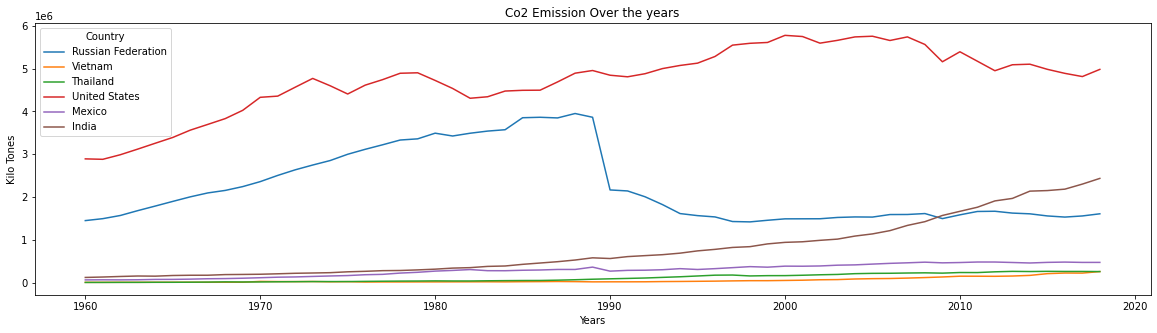

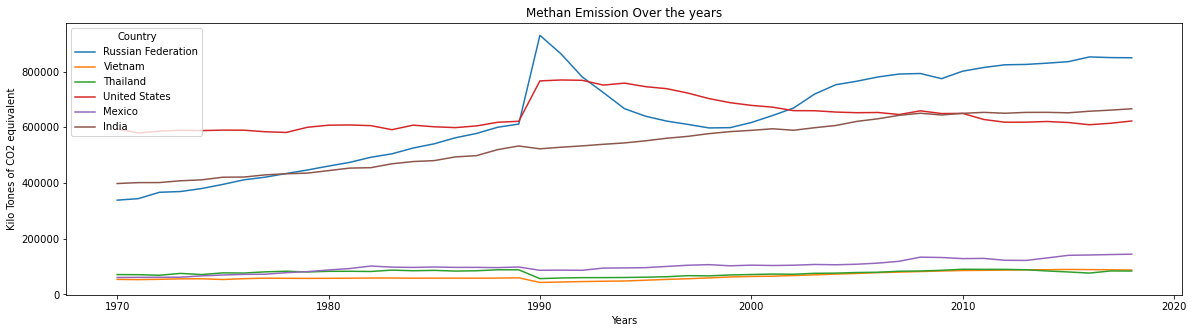

In [ ]:
def print_piechart_sum(df, title, value):
    Temp = df.reset_index()
    varr = Temp.sum(axis = 1)
    Temp[f"{value}"] = varr
    fig1 = px.pie(Temp,
                                    values=f"{value}", 
                                    names='Country',
                                    title=f'{title}')
    fig1.show()

def print_lineplot_sum(df, title, ylabel):
    df.plot(figsize=(20,5))
    plt.xlabel('Years')
    plt.ylabel(f'{ylabel}') 
    plt.title(f'{title}')
    plt.show()

def print_barplot_sum(df, title, ylabel):
    ssc = df[["Russian Federation", "Vietnam", "Thailand", "United States", "Mexico", "India"]].T
    ssy = ssc[["2018"]]
    ssy = ssy.reset_index()
    fig, ax1 = plt.subplots(figsize=(20, 10), dpi=100)
    sns.set_theme(style="whitegrid")
    tr = ssy.melt(id_vars='Country').rename(columns=str.title)
    tr = tr.rename(columns={"Variable": "Years", "Value": f'{ylabel}'})
    sns.barplot(x='Country', y=f'{ylabel}', hue='Years', data=tr, ax=ax1)
    fig.suptitle(f'{title}', fontsize=30)
    sns.despine(fig)

print_piechart_sum(selected_countries_co2, "Total Co2 emmision Between 1962-2020 per country", "Kilo Tone")
print(selected_countries_co2.sum(axis = 1))

print_piechart_sum(selected_countries_me, "Total Co2 emmision Between 1962-2020 per country", "Kilo Tones of CO2 equivalent")
print(selected_countries_me.sum(axis = 1))

print_lineplot_sum(co2, "Co2 Emission Over the years", "Kilo Tones")
print_lineplot_sum(me, "Methan Emission Over the years", "Kilo Tones of CO2 equivalent")

## Question 4 - Prediction

* Can these characteristics also predict trends in the number of endangered species?
    * What countries have higher number of co2/methan emissions?
    * How does this characteristics change over time?

In [ ]:
country_co2_raw = pd.read_csv("../data/country/CO2/API_EN.ATM.CO2E.KT_DS2_en_csv_v2_3470002.csv", quotechar = '"', skiprows=4)
country_fst_raw = pd.read_csv("../data/country/Forest/API_AG.LND.FRST.ZS_DS2_en_csv_v2_3469441.csv", quotechar = '"', skiprows=4)
country_pop_raw = pd.read_csv("../data/country/Population/API_SP.POP.GROW_DS2_en_csv_v2_3469469.csv", quotechar = '"', skiprows=4)
country_me_raw = pd.read_csv("../data/country/methan/API_EN.ATM.METH.KT.CE_DS2_en_csv_v2_3471999.csv", quotechar = '"', skiprows=4)
country_re_raw = pd.read_csv("../data/country/RE/API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_3471475.csv", quotechar = '"', skiprows=4)

def trs_data(df, value_name):
    temp = (df
                        .rename(columns={"Country Code": "Code"})
                        .drop(['Indicator Code', 'Indicator Name', 'Country Name', '2020', '2019', 'Unnamed: 65'], axis=1)
                        .melt(id_vars=['Code'],var_name='year', value_name=f'{value_name}'))
    return temp


df1 = trs_data(country_co2_raw, 'co2')
df2 = trs_data(country_fst_raw, 'forest')
df3 = trs_data(country_pop_raw, 'population')
df4 = trs_data(country_me_raw, 'methan')
df5 = trs_data(country_re_raw, 'renewable_energy')

df = animalia_df.join(country_df, how='left')
historical_df = historical_df.drop(['category', 'code'], axis=1)
dfs = df.join(historical_df, how='left')
dfs_min = dfs[['assessment_date', 'category', 'country', 'code_3', 'assess_year']]
dfs_min= dfs_min.rename(columns={"assess_year": "year", "code_3": "Code"})

merge = pd.merge(df1, df2, on=['Code', 'year'])
merge = pd.merge(merge, df3, on=['Code', 'year'])
merge = pd.merge(merge, df4, on=['Code', 'year'])
merge_data = pd.merge(merge, df5, on=['Code', 'year'])
merge_data["year"] = merge_data["year"].astype(str).astype(int)

final = dfs_min.merge(merge_data, how='right', on=['Code', 'year'])

In [ ]:
hist_df = iucn_data.get_merged_historical_info().reset_index()
cat = ["Endangered", "Critically Endangered", "Vulnerable"]
label_mapping = {"Critically Endangered":"CR", "Endangered":"EN", "Vulnerable":"VU"}
cat_cols = ["indianred", "lightblue", "darkred"]
df = hist_df.query(f'category in {cat}')

df['category'] = df['category'].map(label_mapping)

df = df.groupby(['taxonid_iucn', 'category'])['year'].min().reset_index()
df = df.groupby(['year', 'category']).count()
df.columns = ['counts']

df['no_csum'] = df.groupby(['category'])['counts'].cumsum()



df_splt = df.reset_index()

predict_df = df_splt.merge(final, how='right', on=['category', 'year'])
corr = df_splt.merge(final, how='right', on=['category', 'year'])
predict_df = predict_df.dropna(subset = ['co2', 'forest', 'population', 'methan', 'renewable_energy', 'category']).reset_index(drop=True)
predict_df['assessment_date'] =  pd.to_datetime(predict_df['assessment_date'])
predict_df = predict_df.rename(columns={"assessment_date": "ds", "no_csum": "y"})

<ipython-input-50-f7e4f9795e9d>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                      year    counts         y       co2    forest  \
year              1.000000 -0.243022  0.907064 -0.032644 -0.028126   
counts           -0.243022  1.000000 -0.055426  0.016407  0.031845   
y                 0.907064 -0.055426  1.000000 -0.015946 -0.021967   
co2              -0.032644  0.016407 -0.015946  1.000000 -0.070298   
forest           -0.028126  0.031845 -0.021967 -0.070298  1.000000   
population       -0.078897  0.001777 -0.072916 -0.174400 -0.104481   
methan           -0.052380  0.030216 -0.031644  0.870095 -0.041505   
renewable_energy -0.048258  0.015936 -0.049470 -0.249334  0.135298   

                  population    methan  renewable_energy  
year               -0.078897 -0.052380         -0.048258  
counts              0.001777  0.030216          0.015936  
y                  -0.072916 -0.031644         -0.049470  
co2                -0.174400  0.870095         -0.249334  
forest             -0.104481 -0.041505          0.135298  
population     

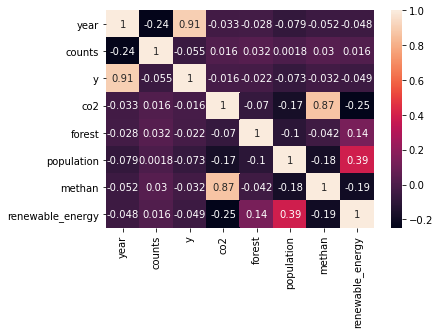

In [ ]:
corrMatrix = predict_df.corr()
print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
## split train test
##

f_train = predict_df.loc[predict_df["ds"]<"2010-01-01"]
f_test = predict_df.loc[predict_df["ds"]>"2010-01-01"]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


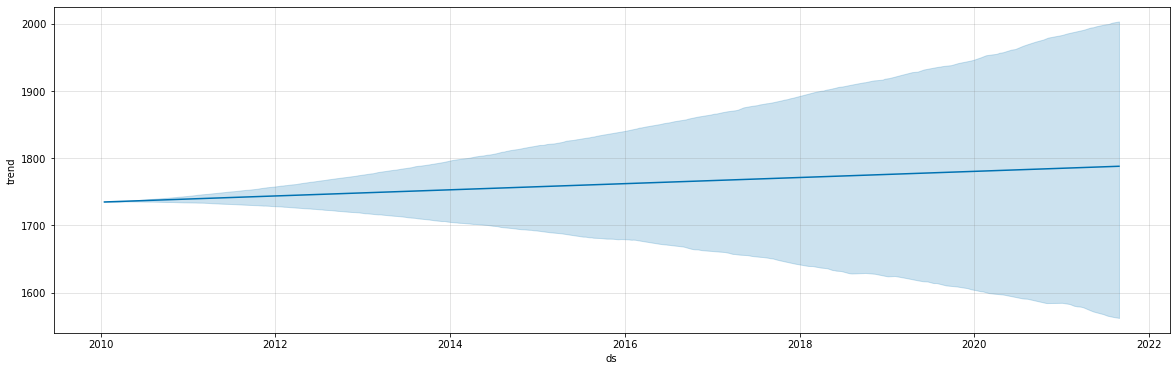

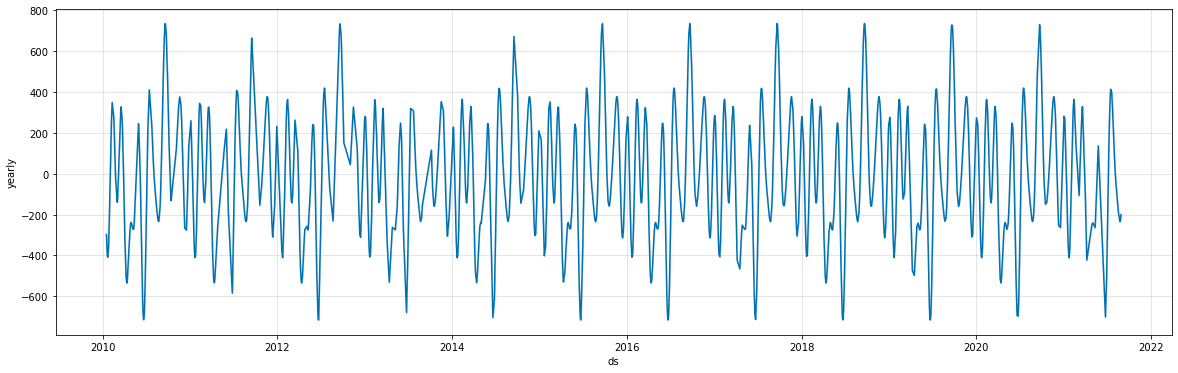

In [ ]:
## Prediction Without charectiristics
##

m = Prophet()

m.fit((f_train))


forcast = m.predict(f_test.drop(columns="y"))
plot_forecast_component(m, forcast, name='trend', uncertainty=True, figsize=(20, 6))
plot_forecast_component(m, forcast, name='yearly', uncertainty=True, figsize=(20, 6))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


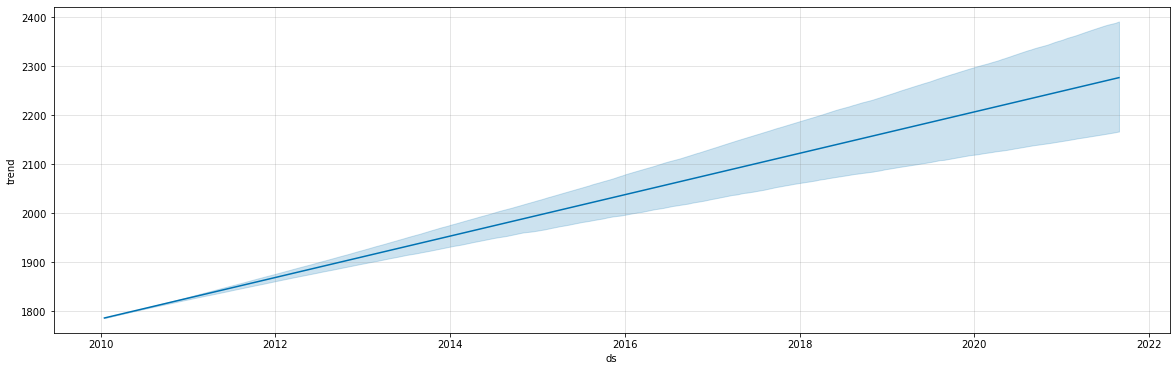

In [ ]:
## prediction with Charectiristics

m = Prophet()

m.add_regressor('co2')
m.add_regressor('forest')
m.add_regressor('population')
m.add_regressor('methan')
m.add_regressor('renewable_energy')

m.fit((f_train))


forcast = m.predict(f_test.drop(columns="y"))
plot_forecast_component(m, forcast, name='trend', uncertainty=True, figsize=(20, 6))